### 1. 데이터 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

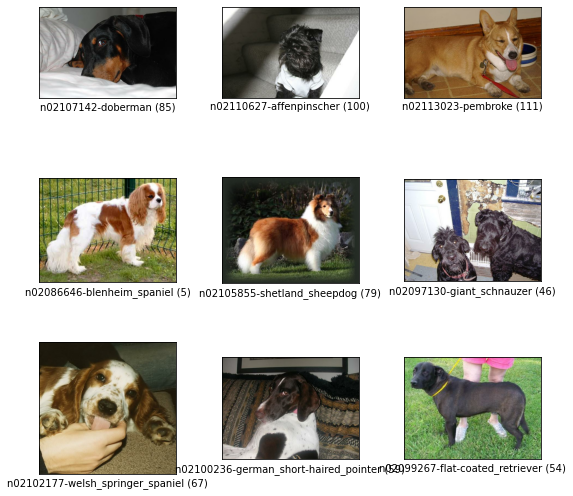

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

### 2. Argumentation 적용

#### (1) flip

In [5]:
# 이미지를 변환하기 위한 전처리 함수
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
# 좌우 대칭
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

#### (2) Cutmix
- 데이터를 자르고 섞음

In [7]:
#배치 내의 이미지를 2개 골라  섞음
# a : 바탕 이미지, b : 삽입될 이미지
def get_clip_box(image_a, image_b,img_size=224):
    # mage.shape = (height, width, channel)
    #print("get_clip")
    
    # 이미지 a,b가 모두 (224,224)로 resize되어 있기 때문에 필요 x
    # 아래 코드는 width, height가 다르더라고 가변적으로 적용할 수 있게 구현할 때 필요
    #image_size_x = image_a.shape[1]
    #image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width, height of box
    width = tf.cast(img_size * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(img_size * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(img_size, x+width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    
    return xa, ya, xb, yb

In [8]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    #print("mix_2_images")
    #image_size_x = image_a.shape[1]
    #image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [9]:
# 면적에 비례하여 라벨을 섞음
def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    #print("mix_2_label")
    #image_size_x = image_a.shape[1]
    #image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size * img_size
    a = tf.cast(mixed_area/total_area, tf.float32)
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label


In [10]:
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### (3) Mixup

In [11]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [12]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

---

In [13]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    imgs = []
    labels = []
    for i in range(batch_size):
        imgs.append(image[i])
        labels.append(tf.one_hot(label[i], num_classes))
    imgs = tf.reshape(tf.stack(imgs), (batch_size, img_size, img_size, 3))
    return imgs, labels

In [14]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
        
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls = 2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls = 2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 3. 비교실험

In [15]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False) # augmentation 적용 x
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True) # augmentation 적용 
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)
ds_train_with_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix = True)
ds_train_with_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup = True)

In [16]:
num_classes = ds_info.features["label"].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, #imagenet의 클래스 수와 다르기 때문에 fully connected layer를 가져오지 않음. 
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
    # 강아지인지 아닌지 판별하기 위한 모델이므로 Softmax(0~1사이의 값으로 정규화)를 사용 
])

In [17]:
# augmentation을 적용한 데이터셋으로 학습시킬 ResNet
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [18]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [19]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [20]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 30

tf.random.set_seed(2020)

resnet50.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_with_cutmix = cutmix_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_resnet50_with_mixup = mixup_resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
750/750 [==============================] - ETA: 0s - loss: 2.2122 - accuracy: 0.4423WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0070s vs `on_test_batch_end` time: 0.0287s). Check your callbacks.


750/750 [==============================] - 110s 147ms/step - loss: 2.2122 - accuracy: 0.4423 - val_loss: 3.5425 - val_accuracy: 0.1881
Epoch 2/30
750/750 [==============================] - 111s 147ms/step - loss: 0.7848 - accuracy: 0.7774 - val_loss: 1.4719 - val_accuracy: 0.5872
Epoch 3/30
750/750 [==============================] - 111s 148ms/step - loss: 0.2236 - accuracy: 0.9538 - val_loss: 0.9274 - val_accuracy: 0.7253
Epoch 4/30
750/750 [==============================] - 114s 153ms/step - loss: 0.0584 - accuracy: 0.9953 - val_loss: 0.9041 - val_accuracy: 0.7420
Epoch 5/30
750/750 [==============================] - 111s 148ms/step - loss: 0.0251 - accuracy: 0.9990 - val_loss: 0.9283 - val_accuracy: 0.7351
Epoch 6/30
750/750 [==============================] - 111s 148ms/step - loss: 0.0444 - accuracy: 0.9967 - val_loss: 0.9508 - val_accuracy: 0.7332
Epoch 7/30
750/750 [==============================] - 111s 148ms/step - loss: 0.0177 - accuracy: 0.9987 - val_loss: 0.9565 - val_accura

750/750 [==============================] - ETA: 0s - loss: 2.1992 - accuracy: 0.4462WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0073s vs `on_test_batch_end` time: 0.0292s). Check your callbacks.


750/750 [==============================] - 111s 148ms/step - loss: 2.1992 - accuracy: 0.4462 - val_loss: 2.8431 - val_accuracy: 0.2969
Epoch 2/30
750/750 [==============================] - 111s 148ms/step - loss: 0.9530 - accuracy: 0.7258 - val_loss: 1.1944 - val_accuracy: 0.6581
Epoch 3/30
750/750 [==============================] - 111s 148ms/step - loss: 0.4709 - accuracy: 0.8737 - val_loss: 1.0326 - val_accuracy: 0.6965
Epoch 4/30
750/750 [==============================] - 111s 148ms/step - loss: 0.2930 - accuracy: 0.9233 - val_loss: 0.9758 - val_accuracy: 0.7171
Epoch 5/30
750/750 [==============================] - 111s 148ms/step - loss: 0.1401 - accuracy: 0.9714 - val_loss: 1.3642 - val_accuracy: 0.6496
Epoch 6/30
750/750 [==============================] - 111s 148ms/step - loss: 0.1229 - accuracy: 0.9753 - val_loss: 0.9991 - val_accuracy: 0.7200
Epoch 7/30
750/750 [==============================] - 111s 148ms/step - loss: 0.0858 - accuracy: 0.9847 - val_loss: 1.0269 - val_accura

750/750 [==============================] - ETA: 0s - loss: 2.2183 - accuracy: 0.4444WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0075s vs `on_test_batch_end` time: 0.0335s). Check your callbacks.


750/750 [==============================] - 126s 168ms/step - loss: 2.2183 - accuracy: 0.4444 - val_loss: 3.4633 - val_accuracy: 0.1968
Epoch 2/30
750/750 [==============================] - 127s 170ms/step - loss: 0.7909 - accuracy: 0.7735 - val_loss: 1.0988 - val_accuracy: 0.6807
Epoch 3/30
750/750 [==============================] - 128s 171ms/step - loss: 0.2996 - accuracy: 0.9285 - val_loss: 0.9723 - val_accuracy: 0.7156
Epoch 4/30
750/750 [==============================] - 128s 171ms/step - loss: 0.0845 - accuracy: 0.9914 - val_loss: 0.9227 - val_accuracy: 0.7338
Epoch 5/30
750/750 [==============================] - 128s 170ms/step - loss: 0.0509 - accuracy: 0.9964 - val_loss: 0.9425 - val_accuracy: 0.7329
Epoch 6/30
750/750 [==============================] - 128s 170ms/step - loss: 0.0175 - accuracy: 0.9995 - val_loss: 0.9297 - val_accuracy: 0.7429
Epoch 7/30
750/750 [==============================] - 128s 170ms/step - loss: 0.0093 - accuracy: 0.9999 - val_loss: 0.9362 - val_accura

750/750 [==============================] - ETA: 0s - loss: 2.2303 - accuracy: 0.4469WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0080s vs `on_test_batch_end` time: 0.0315s). Check your callbacks.


750/750 [==============================] - 120s 160ms/step - loss: 2.2303 - accuracy: 0.4469 - val_loss: 3.3541 - val_accuracy: 0.2129
Epoch 2/30
750/750 [==============================] - 119s 159ms/step - loss: 0.7846 - accuracy: 0.7790 - val_loss: 1.0606 - val_accuracy: 0.6865
Epoch 3/30
750/750 [==============================] - 120s 159ms/step - loss: 0.3100 - accuracy: 0.9273 - val_loss: 1.0022 - val_accuracy: 0.7119
Epoch 4/30
750/750 [==============================] - 120s 159ms/step - loss: 0.1119 - accuracy: 0.9827 - val_loss: 0.9270 - val_accuracy: 0.7372
Epoch 5/30
750/750 [==============================] - 119s 159ms/step - loss: 0.0359 - accuracy: 0.9974 - val_loss: 0.9246 - val_accuracy: 0.7401
Epoch 6/30
750/750 [==============================] - 120s 160ms/step - loss: 0.0294 - accuracy: 0.9984 - val_loss: 0.9189 - val_accuracy: 0.7446
Epoch 7/30
750/750 [==============================] - 120s 159ms/step - loss: 0.0129 - accuracy: 0.9994 - val_loss: 0.9206 - val_accura

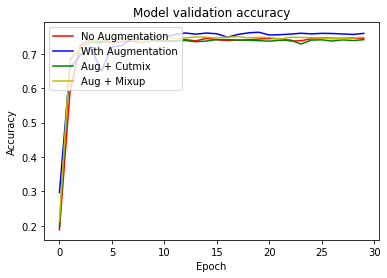

In [21]:
# 훈련 과정 시각화 
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_with_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_with_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'Aug + Cutmix', 'Aug + Mixup'], loc='upper left')
plt.show()

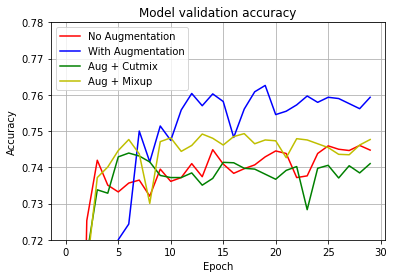

In [25]:
# 위의 내용을 확대해서 살펴보기
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_with_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_with_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'Aug + Cutmix', 'Aug + Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.78)
plt.show()